((12, 4, True), 0.0223214285714286)
((4, 5, False), -0.34024896265560167)
((14, 7, True), 0.0211946050096339)
((14, 3, True), -0.0714285714285714)
((17, 7, True), -0.12647058823529408)
((12, 6, True), -0.05999999999999991)
((4, 3, False), -0.271889400921659)
((4, 9, False), -0.34322033898305077)
((5, 1, False), -0.4411085450346418)
((4, 8, False), -0.3648648648648648)


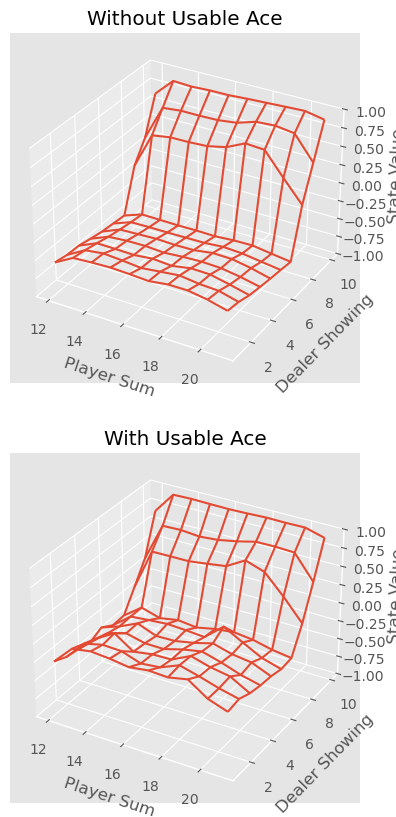

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

# Initialize environment
env = gym.make('Blackjack-v1')

# Define a policy where we hit until we reach 19.
# actions: 0 = stand, 1 = hit
def sample_policy(observation):
    if len(observation) == 3:
        score, dealer_score, usable_ace = observation
    elif len(observation) == 2:  # Some versions return only (score, dealer_score)
        score, dealer_score = observation
        usable_ace = False  # Default to False if not provided
    
    return 0 if score >= 19 else 1

# Generate an episode - game from start to terminal state
def generate_episode(policy, env):
    states, actions, rewards = [], [], []
    observation, _ = env.reset()  # Newer Gym versions return (observation, info)

    while True:
        states.append(observation)
        action = sample_policy(observation)
        actions.append(action)
        
        observation, reward, done, _, _ = env.step(action)  # Newer Gym versions return (obs, reward, done, truncated, info)
        rewards.append(reward)
        
        if done:
            break
                
    return states, actions, rewards

def first_visit_mc_prediction(policy, env, n_episodes):
    value_table = defaultdict(float)
    N = defaultdict(int)

    for _ in range(n_episodes):
        states, _, rewards = generate_episode(policy, env)
        returns = 0
        
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            
            returns += R
            
            if S not in states[:t]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
    
    return value_table

# Run MC Prediction
value = first_visit_mc_prediction(sample_policy, env, n_episodes=500000)

# Print some state values
for i in range(10):
    print(value.popitem())

# Function to plot Blackjack state values
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 22)  # 12 to 21
    dealer_sum = np.arange(1, 11)   # 1 to 10
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_sum), len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_sum):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V.get((player, dealer, ace), 0)  # Use .get() to avoid missing key errors

    X, Y = np.meshgrid(player_sum, dealer_sum)
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])

    for ax in (ax1, ax2):
        ax.set_zlim(-1, 1)
        ax.set_ylabel('Dealer Showing')
        ax.set_xlabel('Player Sum')
        ax.set_zlabel('State Value')

# Plot results
fig, axes = pyplot.subplots(nrows=2, figsize=(10, 10), subplot_kw={'projection': '3d'})
axes[0].set_title('Without Usable Ace')
axes[1].set_title('With Usable Ace')

plot_blackjack(value, axes[0], axes[1])
plt.show()
